In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Bidirectional, LSTM, Layer

In [2]:
LABEL_DIR = "E:\\Xebia Internship\\dataset\\musicnet\\musicnet\\train_labels\\"
AUDIO_DIR = "E:\\Xebia Internship\\dataset\\musicnet\\musicnet\\train_data\\"

In [3]:
LABEL_DIR_TEST = "E:\\Xebia Internship\\dataset\\musicnet\\musicnet\\test_labels\\"
AUDIO_DIR_TEST = "E:\\Xebia Internship\\dataset\\musicnet\\musicnet\\test_data\\"

In [4]:
audio_file = pd.DataFrame(columns = ['audio', 'instrument'])

In [5]:
for i in os.listdir(LABEL_DIR):
    
    audio_csv = pd.read_csv("{}\\{}".format(LABEL_DIR, i))
    
    audio_file = audio_file.append({'audio':i,
                          'instrument':",".join(audio_csv['instrument'].unique().astype(str))}, ignore_index = True)

In [6]:
audio_file.head()

,audio,instrument
0,1727.csv,"43,42,1,44,41"
1,1728.csv,"42,41,43,1,44"
2,1729.csv,"41,42,43,44,1"
3,1730.csv,"43,42,1,44,41"
4,1733.csv,1


In [7]:
instruments = audio_file['instrument'].str.get_dummies(sep=',')
instruments.head()

,1,41,42,43,44,61,69,7,71,72,74
0,1,1,1,1,1,0,0,0,0,0,0
1,1,1,1,1,1,0,0,0,0,0,0
2,1,1,1,1,1,0,0,0,0,0,0
3,1,1,1,1,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0


In [8]:
audio_file_test = pd.DataFrame(columns = ['audio', 'instrument'])

In [9]:
for i in os.listdir(LABEL_DIR_TEST):
    
    audio_csv = pd.read_csv("{}\\{}".format(LABEL_DIR_TEST, i))
    
    audio_file_test = audio_file_test.append({'audio':i,
                          'instrument':",".join(audio_csv['instrument'].unique().astype(str))}, ignore_index = True)

In [10]:
instruments_test = audio_file_test['instrument'].str.get_dummies(sep=',')
instruments_test.head()

,1,41,42,43,61,71,72
0,1,0,0,0,0,0,0
1,0,0,0,0,1,1,1
2,0,1,1,1,0,0,0
3,0,1,0,0,0,0,0
4,0,0,0,1,0,0,0


In [11]:
instruments_test['44'] = pd.Series([0]*10, index=instruments_test.index)
instruments_test['69'] = pd.Series([0]*10, index=instruments_test.index)
instruments_test['7'] = pd.Series([0]*10, index=instruments_test.index)
instruments_test['74'] = pd.Series([0]*10, index=instruments_test.index)

In [12]:
instruments_test = instruments_test[['1','41','42','43','44','61','69','7','71','72','74']]
instruments_test.head()

,1,41,42,43,44,61,69,7,71,72,74
0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,1,1,0
2,0,1,1,1,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0


In [13]:
n_instruments = 11

In [14]:
sr = 44100
duration = 5
samples = sr * duration

In [15]:
#Reads in the audio file and returns an array that we can turn into a melspectogram

def read_audio(path):
    y, _ = librosa.core.load(path, sr=44100)
    
    # trim silence
    if 0 < len(y): # workaround: 0 length causes error
        y, _ = librosa.effects.trim(y)
    if len(y) > samples: # long enough
        y = y[0:0+samples]
    else: # pad blank
        padding = samples - len(y)
        offset = padding // 2
        y = np.pad(y, (offset, samples - len(y) - offset), 'constant')
    return y

In [16]:
#Convert audio to melspectrogram

def audio_to_melspectrogram(audio):
    
    spectrogram = librosa.feature.melspectrogram(audio, 
                                                 sr=sr)
    
    return librosa.power_to_db(spectrogram).astype(np.float32)

def read_as_melspectrogram(path):
    
    mels = audio_to_melspectrogram(read_audio(path))
    return mels

In [17]:
def convert_wav_to_image(df, path):
    X = []
    for _, row in tqdm(df.iterrows()):
        x = read_as_melspectrogram('{}{}.wav'.format(path, str(row['audio']).split('.')[0]))
        X.append(x.transpose())
    
    return X

def normalize(img):
    eps = 0.001
    if np.std(img) != 0:
        img = (img - np.mean(img)) / np.std(img)
    else:
        img = (img - np.mean(img)) / eps
    return img

def normalize_dataset(X):
    normalized_dataset = []
    for img in X:
        normalized = normalize(img)
        normalized_dataset.append(normalized)
    return normalized_dataset

In [18]:
X = np.array(convert_wav_to_image(audio_file, AUDIO_DIR))

0it [00:00, ?it/s]

In [19]:
X = normalize_dataset(X)

In [20]:
Y = instruments.values

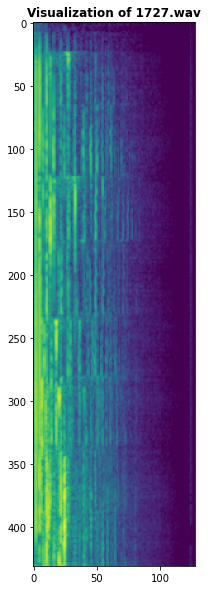

In [21]:
# Visualize an melspectogram example

plt.figure(figsize=(15,10))
plt.title('Visualization of 1727.wav', weight='bold')
plt.imshow(X[0])
plt.show()

In [22]:
X_test = np.array(convert_wav_to_image(audio_file_test, AUDIO_DIR_TEST))

0it [00:00, ?it/s]

In [23]:
X_test = normalize_dataset(X_test)

In [24]:
Y_test = instruments_test.values

In [25]:
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        #self.supports_masking = True
        self.init = initializers.get('glorot_uniform')
        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)
        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)
        self.bias = bias
        self.step_dim = step_dim
        #self.features_dim = 0
        super(Attention, self).__init__(**kwargs)
        
    def get_config(self):
        config = super().get_config().copy()
        config.update({
         #   'supports_masking': self.supports_masking,
            'W_regularizer': self.W_regularizer,
            'b_regularizer': self.b_regularizer,
            'W_constraint': self.W_constraint,
            'b_constraint': self.b_constraint,
            'bias': self.bias,
            'step_dim': self.step_dim
         #   'features_dim': self.features_dim,
        })
        return config

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None
        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))
        if self.bias:
            eij += self.b
        eij = K.tanh(eij)
        a = K.exp(eij)
        if mask is not None:
            a *= K.cast(mask, K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [26]:
# LSTM Model
input_shape = (431,128)

model = Sequential()

model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=input_shape))
model.add(Attention(431))
model.add(Dropout(0.2))
model.add(Dense(16))
model.add(Dropout(0.2)) 
model.add(Dense(n_instruments, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['acc'])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 431, 128)          98816     
_________________________________________________________________
attention (Attention)        (None, 128)               559       
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                2064      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 11)                187       
Total params: 101,626
Trainable params: 101,626
Non-trainable params: 0
__________________________________________________

In [28]:
# Training model
history = model.fit(np.array(X), Y, epochs=250)

Epoch 1/250
10/10 [==============================] - 3s 34ms/step - loss: 4.2160 - acc: 0.3969
Epoch 2/250
10/10 [==============================] - 0s 28ms/step - loss: 5.7281 - acc: 0.5494
Epoch 3/250
10/10 [==============================] - 0s 28ms/step - loss: 6.9003 - acc: 0.5438
Epoch 4/250
10/10 [==============================] - 0s 29ms/step - loss: 6.9222 - acc: 0.5835
Epoch 5/250
10/10 [==============================] - 0s 29ms/step - loss: 9.0116 - acc: 0.5474
Epoch 6/250
10/10 [==============================] - 0s 29ms/step - loss: 10.8847 - acc: 0.4260
Epoch 7/250
10/10 [==============================] - 0s 29ms/step - loss: 11.1396 - acc: 0.5490
Epoch 8/250
10/10 [==============================] - 0s 29ms/step - loss: 14.2984 - acc: 0.4882
Epoch 9/250
10/10 [==============================] - 0s 29ms/step - loss: 15.7050 - acc: 0.3805
Epoch 10/250
10/10 [==============================] - 0s 29ms/step - loss: 15.7087 - acc: 0.4868
Epoch 11/250
10/10 [========================

10/10 [==============================] - 0s 28ms/step - loss: 217.9658 - acc: 0.3803
Epoch 85/250
10/10 [==============================] - 0s 29ms/step - loss: 243.1861 - acc: 0.3461
Epoch 86/250
10/10 [==============================] - 0s 31ms/step - loss: 216.8726 - acc: 0.3659
Epoch 87/250
10/10 [==============================] - 0s 31ms/step - loss: 241.3913 - acc: 0.3592
Epoch 88/250
10/10 [==============================] - 0s 29ms/step - loss: 238.2471 - acc: 0.3224
Epoch 89/250
10/10 [==============================] - 0s 28ms/step - loss: 268.1123 - acc: 0.3420
Epoch 90/250
10/10 [==============================] - 0s 30ms/step - loss: 242.9515 - acc: 0.3784
Epoch 91/250
10/10 [==============================] - 0s 30ms/step - loss: 259.4847 - acc: 0.3749
Epoch 92/250
10/10 [==============================] - 0s 31ms/step - loss: 233.8288 - acc: 0.3450
Epoch 93/250
10/10 [==============================] - 0s 28ms/step - loss: 223.9808 - acc: 0.3757
Epoch 94/250
10/10 [=============

10/10 [==============================] - 0s 29ms/step - loss: 478.5473 - acc: 0.4005
Epoch 167/250
10/10 [==============================] - 0s 29ms/step - loss: 458.6564 - acc: 0.3529
Epoch 168/250
10/10 [==============================] - 0s 30ms/step - loss: 377.4380 - acc: 0.3208
Epoch 169/250
10/10 [==============================] - 0s 31ms/step - loss: 394.6887 - acc: 0.3424
Epoch 170/250
10/10 [==============================] - 0s 30ms/step - loss: 489.1916 - acc: 0.3206
Epoch 171/250
10/10 [==============================] - 0s 29ms/step - loss: 453.9668 - acc: 0.3582
Epoch 172/250
10/10 [==============================] - 0s 32ms/step - loss: 342.9734 - acc: 0.3606
Epoch 173/250
10/10 [==============================] - 0s 30ms/step - loss: 527.4500 - acc: 0.3385
Epoch 174/250
10/10 [==============================] - ETA: 0s - loss: 436.9043 - acc: 0.315 - 0s 30ms/step - loss: 440.1778 - acc: 0.3177
Epoch 175/250
10/10 [==============================] - 0s 29ms/step - loss: 429.198

10/10 [==============================] - 0s 30ms/step - loss: 621.5390 - acc: 0.3635
Epoch 248/250
10/10 [==============================] - 0s 29ms/step - loss: 674.1338 - acc: 0.3593
Epoch 249/250
10/10 [==============================] - 0s 31ms/step - loss: 634.1531 - acc: 0.3523
Epoch 250/250
10/10 [==============================] - 0s 30ms/step - loss: 499.6968 - acc: 0.3543


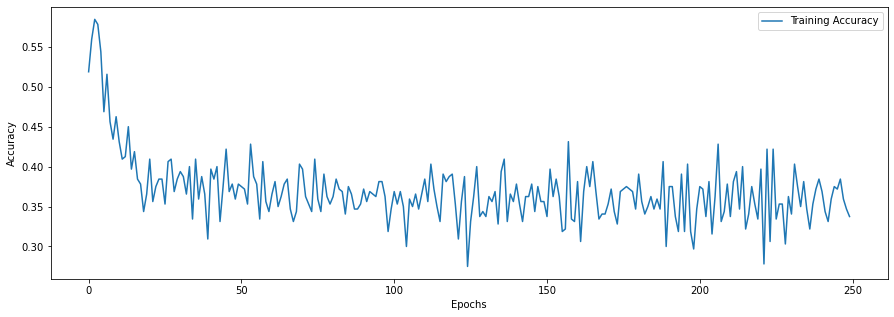

In [29]:
# Accuracy Visualization
epochs = range(250)

plt.figure(figsize=(15,5))
plt.plot(epochs, history.history['acc'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy'])
plt.show()

In [30]:
model.save("model.h5")